# Wine-Net: Exploring Wine Through Deep Learning

In [1]:
# !pip install pandas
# !pip install seaborn
# !pip install sklearn
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.preprocessing import sequence
import os 
from tensorflow.keras.layers import Dense, LSTM, Embedding,Dropout,SpatialDropout1D,Conv1D,MaxPooling1D,GRU,BatchNormalization
from tensorflow.keras.layers import Input,Bidirectional,GlobalAveragePooling1D,GlobalMaxPooling1D,concatenate,LeakyReLU
from tensorflow.keras import regularizers  
from tensorflow.keras import backend as K


os.chdir('/content/drive/MyDrive/NeuralResearch/wine-net/')

def remove_punctuation(s):
  punc = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
  for ele in s:
      if ele in punc:
          s = s.replace(ele, "")
  return s

def clean_description(review, swap):
  terms = review.split()
  for x in terms:
    try: x = swap[('t_' + str(x))]
    except KeyError: x = ''
  return ' '.join(terms)


## Data Import and Cleaning

In [3]:
wines = pd.read_csv('winemag-data-130k-v2.csv')
wines = wines.drop(columns = ['Unnamed: 0'])
wines2 = pd.read_csv('winemag-data_first150k.csv')
wines2.head()

# Intersect and append two review tables
columns = [value for value in wines.columns if value in wines2.columns] 
wines = wines[columns]
wines2 = wines2[columns]
wines = pd.concat([wines, wines2]).drop(columns = ['designation', 'winery'])
wines['d_length'] = wines.description.apply(lambda x: len(str(x))).astype(int)
wines = wines[((wines.d_length > 75) & (wines.d_length < 450))]

# Take sample of data (full dataset requires ~80 GB of RAM)
# wines = wines.sample(n=100000)

# Remove outlier wines
var = list(wines.variety.value_counts()[wines.variety.value_counts() > 9000].index)
wines = wines[wines.variety.isin(var)]



# Imputation steps
median_price = wines.price.median()
median_points = wines.points.median()

# Impute variables
wines.price = wines.price.fillna(median_price)
wines.points = wines.points.fillna(median_points)
wines = wines.fillna('')
wines.price = wines.price.astype(int)
wines.description = wines.description.apply(lambda x: remove_punctuation(x.lower()))

# Constructing Dependent Variables 
## Price regressor
Y_price = wines.price
## Points classifier (is this wine elite?)
Y_points =  wines.points.apply(lambda x: 1 if x > 93 else 0)
## Is this wine red or white?

red_wines = ['Pinot Noir','Cabernet Sauvignon','Red Blend', 
             'Bordeaux-style Red Blend','Syrah','Merlot', 'Zinfandel', 
             'Sangiovese', 'Malbec', 'Nebbiolo', 'Portuguese Red', 
             'Tempranillo Rhône-style Red Blend', 'Shiraz']

Y_red_white = [0 if wines['variety'].iloc[x] in red_wines
               else 1 for x in range(len(wines['variety']))]

Y_red_white = pd.Series(Y_red_white)
output_shape_red_white = Y_red_white.nunique()

Y = wines.variety
output_shape_variety_types = Y.nunique()
wines_dict = {'Pinot Noir': 1, 
                'Chardonnay':2,
                'Cabernet Sauvignon':3,
                'Red Blend':4,
                'Bordeaux-style Red Blend':5,
                'Sauvignon Blanc':6,
                'Riesling':7,
                'Syrah':8,
                'Rosé':9,
                'Merlot':10,
                'Sangiovese':11,
                'Malbec': 12,
                'Zinfandel':13}
Y=[]
for x in wines['variety']:
    Y.append(wines_dict[x])
Y = pd.Series(Y)
Y = Y.to_numpy()

wines.head()

,country,description,points,price,province,region_1,region_2,variety,d_length
3,US,pineapple rind lemon pith and orange blossom s...,87,13,Michigan,Lake Michigan Shore,,Riesling,199
4,US,much like the regular bottling from 2012 this ...,87,65,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,249
10,US,soft supple plum envelopes an oaky structure i...,87,19,California,Napa Valley,Napa,Cabernet Sauvignon,243
12,US,slightly reduced this wine offers a chalky tan...,87,34,California,Alexander Valley,Sonoma,Cabernet Sauvignon,171
14,US,building on 150 years and six generations of w...,87,12,California,Central Coast,Central Coast,Chardonnay,308


## Data Exploration

### Price

[Text(0.5, 1.0, 'Distribution of Wine Prices')]

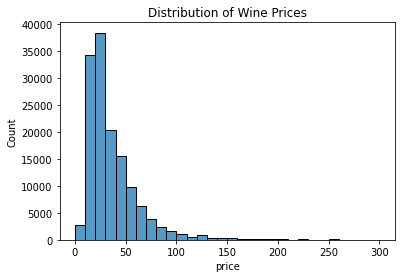

In [4]:
sns.histplot(wines.price,binwidth=10,binrange=(0,300)).set(title='Distribution of Wine Prices')

### Rating Points

In [5]:
# What is the distribution of elite to non-elite wines
Y_points.value_counts()

0    132074
1      7698
Name: points, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


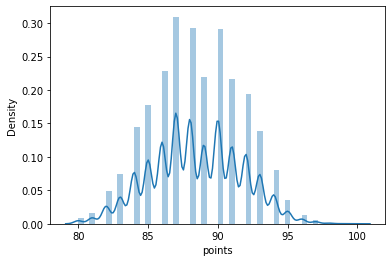

In [6]:
sns.distplot(wines.points)

## Wine Variety (Red or White)

In [7]:
wines.variety.value_counts()

Pinot Noir                  27253
Chardonnay                  26086
Cabernet Sauvignon          21870
Red Blend                   18823
Bordeaux-style Red Blend    14095
Sauvignon Blanc             11248
Riesling                    10578
Syrah                        9819
Name: variety, dtype: int64

([0, 1, 2, 3, 4, 5, 6, 7], <a list of 8 Text major ticklabel objects>)

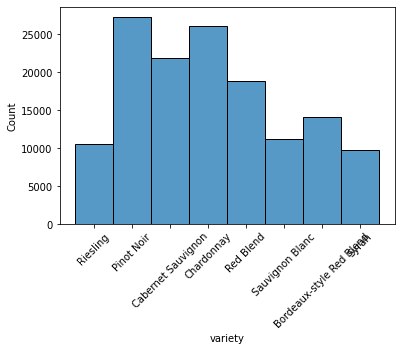

In [8]:
ax = sns.histplot(wines.variety)
plt.xticks(rotation=45) 

In [9]:
Y_red_white.value_counts()

0    91860
1    47912
dtype: int64

In [10]:
wines = wines.drop(columns=['variety', 'price', 'points', 'region_1', 'region_2', 'd_length'])

## Deep Learning

### Preparation

In [11]:
from keras.models import Sequential
from sklearn.preprocessing import LabelEncoder
from keras import layers
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import TensorBoard
from keras.callbacks import EarlyStopping
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout, Flatten
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from collections import OrderedDict
from keras import optimizers

In [12]:
Y_price = Y_price.to_numpy()
Y_points = Y_points.to_numpy()
Y_red_white = Y_red_white.to_numpy()

In [13]:
from keras.preprocessing.text import Tokenizer
X = wines.description.to_numpy()
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X)
num_words = len(tokenizer.word_index)+1
X = tokenizer.texts_to_sequences(X)
max_log_length = 1024
X_processed = sequence.pad_sequences(X, maxlen=max_log_length)
X_processed

array([[   0,    0,    0, ...,  507, 2461,   18],
       [   0,    0,    0, ...,  853, 3635, 2683],
       [   0,    0,    0, ...,    1, 1203, 5471],
       ...,
       [   0,    0,    0, ...,   50,  410,    8],
       [   0,    0,    0, ...,   30, 2186,   81],
       [   0,    0,    0, ...,  635,    2,  225]], dtype=int32)

We introduce an Early stopper below - this allows us to stop training once validation loss goes up after it has been decreasing for a long time.

In [14]:
es = EarlyStopping(monitor='val_loss', mode = 'min', verbose=1, patience=1)

## CNN Build (Red or White)

The first model that we designed was a very simple CNN neural network, with the objective of differentiating the difference between red and white wine. Additionally, by activating a GPU runtime, we are able to create a model that trains extremely fast and delivers awesome results!

In [15]:
modelb = Sequential()
modelb.add(tf.keras.layers.Embedding(input_dim=num_words, output_dim=1024, input_length=max_log_length))
modelb.add(Flatten())
modelb.add(Dense(1, activation='sigmoid'))
modelb.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(), metrics=['accuracy'])
print(modelb.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1024, 1024)        40741888  
                                                                 
 flatten (Flatten)           (None, 1048576)           0         
                                                                 
 dense (Dense)               (None, 1)                 1048577   
                                                                 
Total params: 41,790,465
Trainable params: 41,790,465
Non-trainable params: 0
_________________________________________________________________
None


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_processed, Y_red_white, test_size=0.25, random_state=0)
history_cnn_bin_tokenizer = modelb.fit(x=X_train,y=y_train,validation_split=0.25,epochs=5,batch_size=512,verbose=1, callbacks=[es])

Epoch 1/5
154/154 [==============================] - 223s 1s/step - loss: 0.4147 - accuracy: 0.8967 - val_loss: 0.0343 - val_accuracy: 0.9899
Epoch 2/5
154/154 [==============================] - 220s 1s/step - loss: 0.0215 - accuracy: 0.9948 - val_loss: 0.0239 - val_accuracy: 0.9929
Epoch 3/5
154/154 [==============================] - 221s 1s/step - loss: 0.0105 - accuracy: 0.9982 - val_loss: 0.0214 - val_accuracy: 0.9936
Epoch 4/5
154/154 [==============================] - 220s 1s/step - loss: 0.0056 - accuracy: 0.9993 - val_loss: 0.0208 - val_accuracy: 0.9940
Epoch 5/5
154/154 [==============================] - 220s 1s/step - loss: 0.0030 - accuracy: 0.9998 - val_loss: 0.0211 - val_accuracy: 0.9934
Epoch 5: early stopping


In [17]:
modelb.evaluate(X_test, y_test, batch_size=512)

69/69 [==============================] - 13s 191ms/step - loss: 0.0255 - accuracy: 0.9922


[0.025480791926383972, 0.99224454164505]

As shown below, the model is pretty much ready to go after 1 epoch. After 1 epoch of training, improvements in accuracy are marginal and we begin to see overfitting in model. If we were to save or export this model to production, we would recommend training on 1 epoch.

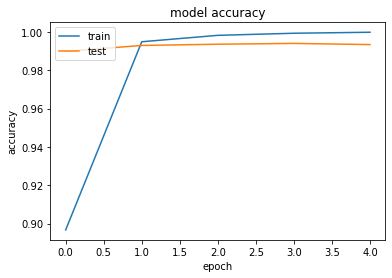

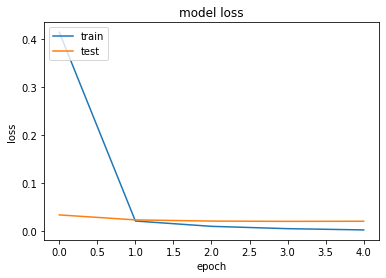

In [18]:
# summarize history for accuracy
plt.plot(history_cnn_bin_tokenizer.history['accuracy'])
plt.plot(history_cnn_bin_tokenizer.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_cnn_bin_tokenizer.history['loss'])
plt.plot(history_cnn_bin_tokenizer.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [19]:
# serialize model to JSON
model_json = modelb.to_json()
with open("tokenized_cnn.json", "w") as json_file:
    json_file.write(model_json)
modelb.save('tokenized_cnn.h5')

## CNN Categorical Model

We're going to use the same model we did above and try to see if we can expand the categories we are trying to classify. In this dependent variable, we are going to try to identify a wine being between 8 different varieties:

* Pinot Noir
* Chardonnay
* Cabernet Sauvignon
* Red Blend
* Bordeaux-style Red Blend
* Sauvignon Blanc
* Riesling
* Syrah

Some of these are red, some of these are white. But the goal is here to identify greater subtleties between the varieties. 

As you can see in the output below, a CNN build does not fare well trying to tackle this problem.

In [20]:
modelc = Sequential()
modelc.add(Embedding(input_dim=X_train.shape[0], output_dim=X_train.shape[1], weights=[X_train], input_length=max_log_length, trainable=False))
modelc.add(Flatten())
modelc.add(Dense(1, activation='sigmoid'))
modelc.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(), metrics=['accuracy'])
print(modelc.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1024, 1024)        107344896 
                                                                 
 flatten_1 (Flatten)         (None, 1048576)           0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1048577   
                                                                 
Total params: 108,393,473
Trainable params: 1,048,577
Non-trainable params: 107,344,896
_________________________________________________________________
None


In [21]:
X_train, X_test, y_train, y_test = train_test_split(X_processed, Y, test_size=0.25, random_state=0)
history_cnn_bin_tokenizer = modelc.fit(x=X_train, y=y_train, validation_split=0.25,epochs=5, batch_size=512, verbose=1, callbacks=[es])

Epoch 1/5
154/154 [==============================] - 72s 460ms/step - loss: 0.0000e+00 - accuracy: 0.1944 - val_loss: 0.0000e+00 - val_accuracy: 0.1980
Epoch 2/5
154/154 [==============================] - 70s 458ms/step - loss: 0.0000e+00 - accuracy: 0.1946 - val_loss: 0.0000e+00 - val_accuracy: 0.1980
Epoch 2: early stopping


In [22]:
modelb.evaluate(X_test, y_test, batch_size=512)

69/69 [==============================] - 13s 192ms/step - loss: 24.5149 - accuracy: 0.0022


[24.514934539794922, 0.002203588606789708]

## RNN Build (Red vs White)
We saw above that CNNs we're good for binary classification, but we wanted to experiment with a more sophisticated model. An RNN might be helpful, since it uses backpropogation to help build context in a neural network. This feature is especially helpful given that we are training on a lot of text data. 

Context of words is likely important, so we're going to start with a Simple RNN and see how it does against the binary classification problem.

In [23]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Embedding(
    input_dim=num_words,
    output_dim=1024,
    input_length=max_log_length
))

model.add(tf.keras.layers.SimpleRNN(
    units = 32,
    activation="relu",
))

model.add(tf.keras.layers.Dense(units=1,activation='relu'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics='accuracy')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 1024, 1024)        40741888  
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                33824     
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 40,775,745
Trainable params: 40,775,745
Non-trainable params: 0
_________________________________________________________________


In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_processed, Y_red_white, test_size=0.25, random_state=0)
history_simple_rnn_bin = model.fit(x=X_train,y=y_train,validation_split=0.25,epochs=5,batch_size=256, callbacks=[es])

Epoch 1/5
308/308 [==============================] - 999s 3s/step - loss: 0.2200 - accuracy: 0.9289 - val_loss: 0.0711 - val_accuracy: 0.9854
Epoch 2/5
308/308 [==============================] - 1021s 3s/step - loss: 0.2046 - accuracy: 0.9757 - val_loss: 0.1610 - val_accuracy: 0.9782
Epoch 2: early stopping


In [25]:
model.evaluate(X_test, y_test, batch_size=256)

137/137 [==============================] - 65s 471ms/step - loss: 0.1728 - accuracy: 0.9780


[0.17280460894107819, 0.9780213236808777]

It would actually appear that the model tends to do well, but is very very slow to train, even with Early Stopping enabled. It's good but we'd still defer to the CNN when it comes to the binary classification problem.

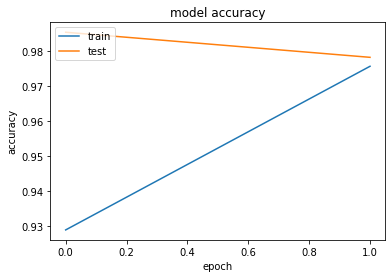

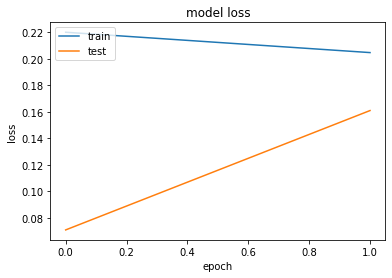

In [26]:
# summarize history for accuracy
plt.plot(history_simple_rnn_bin.history['accuracy'])
plt.plot(history_simple_rnn_bin.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_simple_rnn_bin.history['loss'])
plt.plot(history_simple_rnn_bin.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [27]:
# serialize model to JSON
model_json = model.to_json()
with open("history_simple_rnn_bin.json", "w") as json_file:
    json_file.write(model_json)
model.save('history_simple_rnn_bin.h5')

## RNN Categorical Classifier

Now, we want to use a similar model and try to identify the wine variety (the 8 subvarieties we explored above). We have made two distinct differences between this RNN and the model above:

* The model above has a dense layer with activation function `relu`, which we used for a binary classification problems. In this model, we're going to use `softmax`
* We adjust the loss function to Sparse Categorical Cross-Entropy to account for a hiher number of unique class labels. (Going from 2 -> 8) 

In [28]:
wine_classifier = tf.keras.Sequential()

wine_classifier.add(tf.keras.layers.Embedding(
    input_dim=num_words,
    output_dim=1024,
    input_length=max_log_length
))

wine_classifier.add(tf.keras.layers.SimpleRNN(
    units = 32,
    activation="relu",
))

wine_classifier.add(tf.keras.layers.Dense(10, activation=tf.keras.activations.softmax))
wine_classifier.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics='accuracy')
wine_classifier.summary() 

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 1024, 1024)        40741888  
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 32)                33824     
                                                                 
 dense_3 (Dense)             (None, 10)                330       
                                                                 
Total params: 40,776,042
Trainable params: 40,776,042
Non-trainable params: 0
_________________________________________________________________


In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_processed, Y, test_size=0.25, random_state=0)
history_simple_rnn_v2 = wine_classifier.fit(x=X_train,y=y_train,validation_split=0.25,epochs=7,batch_size=128, callbacks=[es])

Epoch 1/7
615/615 [==============================] - 890s 1s/step - loss: 1.3614 - accuracy: 0.4906 - val_loss: 0.9828 - val_accuracy: 0.6213
Epoch 2/7
615/615 [==============================] - 889s 1s/step - loss: 0.8515 - accuracy: 0.6815 - val_loss: 0.8243 - val_accuracy: 0.6975
Epoch 3/7
615/615 [==============================] - 888s 1s/step - loss: 0.6604 - accuracy: 0.7620 - val_loss: 0.7686 - val_accuracy: 0.7254
Epoch 4/7
615/615 [==============================] - 890s 1s/step - loss: 0.5343 - accuracy: 0.8077 - val_loss: 0.7905 - val_accuracy: 0.7408
Epoch 4: early stopping


In [30]:
wine_classifier.evaluate(X_test, y_test, batch_size=128)

273/273 [==============================] - 93s 342ms/step - loss: 0.7988 - accuracy: 0.7384


[0.798833429813385, 0.7384311556816101]

The model is actually performing very well! There are 8 distinct labels in the class, all roughly uniformly distributed, and it is able to have a test accuracy > 80%! This inspires confidence that the model is really gaining a  great understanding of the differences between the wines.

Furthermore, the model seems to have a very good balance of training error and test error each epoch.

While this model is very powerful, it is also very slow to train. We also experimented this model on Virtual Machines with 128 vCPUs, and we saw that training speed / step did not improve much. When we used heavy GPU instances (including 8 x A5000 Nvidia Setup), it did absolutely nothing.

This model clearly maximizes the performance but it time-costly to train. 

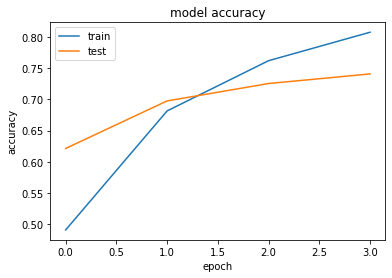

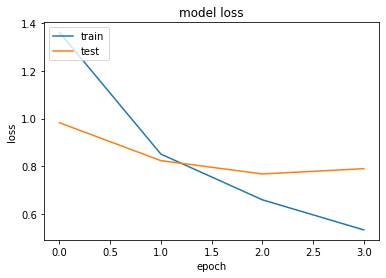

In [31]:
# summarize history for accuracy
plt.plot(history_simple_rnn_v2.history['accuracy'])
plt.plot(history_simple_rnn_v2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_simple_rnn_v2.history['loss'])
plt.plot(history_simple_rnn_v2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch') 
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [32]:
# serialize model to JSON
model_json = model.to_json()
with open("history_simple_rnn_v2.json", "w") as json_file:
    json_file.write(model_json)
model.save('history_simple_rnn_v2.h5')

### RNN Categorical Classifier (LSTM Build)
The structure of this model is effectively the same as the last except we are swapping the `SimpleRNN` layer with a `LSTM` layer. We are keeping the same unit counts and activation functions to compare Apples to Apples.

In [35]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=num_words, output_dim=1024,input_length=max_log_length))
model.add(tf.keras.layers.LSTM (units=32, activation='relu'))
model.add(tf.keras.layers.Dense(units=10,activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer=keras.optimizers.Adam(),metrics='accuracy')
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 1024, 1024)        40741888  
                                                                 
 lstm_1 (LSTM)               (None, 32)                135296    
                                                                 
 dense_5 (Dense)             (None, 10)                330       
                                                                 
Total params: 40,877,514
Trainable params: 40,877,514
Non-trainable params: 0
_________________________________________________________________


In [36]:
X_train, X_test, y_train, y_test = train_test_split(X_processed, Y, test_size=0.25, random_state=0)
history_lstm_rnn = model.fit(x=X_train,y=y_train,validation_split=0.25, epochs=6, batch_size=128, callbacks=[es])

Epoch 1/6
615/615 [==============================] - 1211s 2s/step - loss: 0.9539 - accuracy: 0.6590 - val_loss: 0.5588 - val_accuracy: 0.8056
Epoch 2/6
615/615 [==============================] - 1209s 2s/step - loss: 0.4139 - accuracy: 0.8566 - val_loss: 0.4454 - val_accuracy: 0.8487
Epoch 3/6
615/615 [==============================] - 1199s 2s/step - loss: 0.2959 - accuracy: 0.8999 - val_loss: 0.4557 - val_accuracy: 0.8551
Epoch 3: early stopping


In [37]:
model.evaluate(X_test, y_test, batch_size=128)

273/273 [==============================] - 130s 476ms/step - loss: 0.4599 - accuracy: 0.8550


[0.45993655920028687, 0.8549637794494629]

This model is slower but we are able to achieve a much higher accuracy, clocking in at 85%. We cut the model at epoch 2 to prevent overfitting.

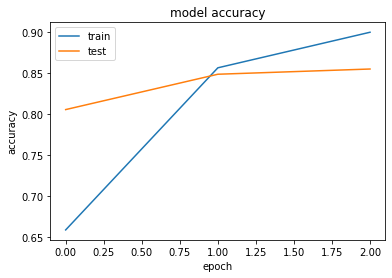

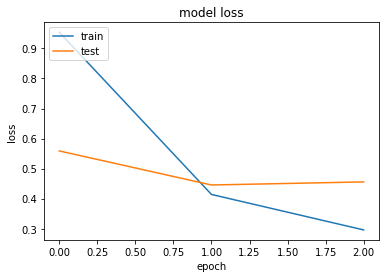

In [38]:
# summarize history for accuracy
plt.plot(history_lstm_rnn.history['accuracy'])
plt.plot(history_lstm_rnn.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_lstm_rnn.history['loss'])
plt.plot(history_lstm_rnn.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [39]:
# serialize model to JSON
model_json = model.to_json()
with open("history_lstm_rnn.json", "w") as json_file:
    json_file.write(model_json)
model.save('history_lstm_rnn.h5')

## RNN Categorical Classifier (LSTM + Dropout)

To improve this model, we applied some regularization techniques to help the model from overfitting very early.

This model is the same as the model above except we:
* Added a recurrent dropout paramter to the LSTM layer
* Added a Dropout layer after the LSTM layer

In the initial runs of this model, we ran into some exploding gradient problems. To combat this, we:
* Added gradient clipping to the optimizer
* Included a learning rate of 0.001 as a safety rail when clipping wasn't helping

In [47]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=num_words, output_dim=1024,input_length=max_log_length))
model.add(tf.keras.layers.LSTM(units=32, activation='relu', recurrent_dropout=0.5))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(units=10,activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy',optimizer=keras.optimizers.Adam(clipvalue=0.5, learning_rate=0.001),metrics='accuracy')
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 1024, 1024)        40741888  
                                                                 
 lstm_6 (LSTM)               (None, 32)                135296    
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_10 (Dense)            (None, 10)                330       
                                                                 
Total params: 40,877,514
Trainable params: 40,877,514
Non-trainable params: 0
_________________________________________________________________


In [48]:
X_train, X_test, y_train, y_test = train_test_split(X_processed, Y, test_size=0.25, random_state=0)
history_lstm_drop_rnn = model.fit(x=X_train,y=y_train,validation_split=0.25, epochs=7, batch_size=128, callbacks=[es])

Epoch 1/7
615/615 [==============================] - 1830s 3s/step - loss: 1.2707 - accuracy: 0.5252 - val_loss: 0.6467 - val_accuracy: 0.7690
Epoch 2/7
615/615 [==============================] - 1814s 3s/step - loss: 0.6311 - accuracy: 0.7815 - val_loss: 0.5232 - val_accuracy: 0.8304
Epoch 3/7
615/615 [==============================] - 1811s 3s/step - loss: 0.4910 - accuracy: 0.8327 - val_loss: 0.4917 - val_accuracy: 0.8423
Epoch 4/7
615/615 [==============================] - 1816s 3s/step - loss: 0.4176 - accuracy: 0.8583 - val_loss: 0.4735 - val_accuracy: 0.8505
Epoch 5/7
615/615 [==============================] - 1808s 3s/step - loss: 0.3688 - accuracy: 0.8752 - val_loss: 0.4860 - val_accuracy: 0.8470
Epoch 5: early stopping


In [49]:
model.evaluate(X_test, y_test, batch_size=128)

273/273 [==============================] - 136s 497ms/step - loss: 0.4858 - accuracy: 0.8477


[0.48575934767723083, 0.8476662039756775]

As our final model, we were able to increase the model's performance by adding 

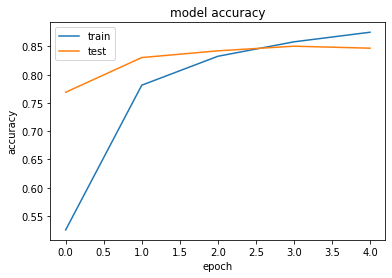

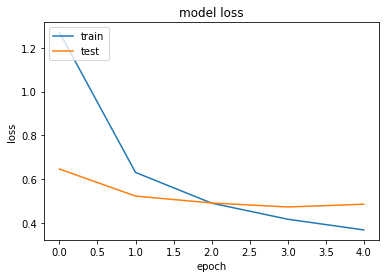

In [50]:
# summarize history for accuracy
plt.plot(history_lstm_drop_rnn.history['accuracy'])
plt.plot(history_lstm_drop_rnn.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_lstm_drop_rnn.history['loss'])
plt.plot(history_lstm_drop_rnn.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [51]:
# serialize model to JSON
model_json = model.to_json()
with open("history_lstm_drop_rnn.json", "w") as json_file:
    json_file.write(model_json)
model.save('history_lstm_drop_rnn.h5')